In [2]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms


class CustomImageDataset(Dataset):
    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_set_path).__next__()[1]

        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if img is not None:
                    all_img_files.append(img_file)
                    all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return image, self.labels[index]

    def __len__(self):
        return self.length

In [3]:
transforms_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor()])

train_data_set = CustomImageDataset(data_set_path="/home/pranjal-ubuntu/Downloads/BrainTumorClassification/data", transforms=transforms_train)
train_loader = DataLoader(train_data_set, batch_size=8, shuffle=True)

In [4]:
batch=next(iter(train_loader))

In [5]:
images = batch[0]
labels = batch[1]

In [6]:
len(batch)

2

In [7]:
type(batch)

list

In [8]:
images.shape

torch.Size([8, 3, 128, 128])

In [9]:
labels.shape

torch.Size([8])

labels : tensor([1, 0, 1, 1, 1, 0, 1, 0])


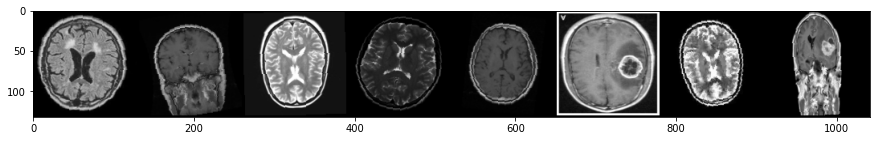

In [10]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print(f"labels : {labels}")

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [20]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5)
    self.fc1 = nn.Linear(in_features=32*29*29,out_features=120)
    self.fc2 = nn.Linear(in_features=120,out_features=60)
    self.out = nn.Linear(in_features=60,out_features=2)

  def forward(self,t):
    t=self.conv1(t)
    t=F.relu(t)
    t=F.max_pool2d(t,kernel_size=2,stride=2)

    t=self.conv2(t)
    t=F.relu(t)
    t=F.max_pool2d(t,kernel_size=2,stride=2)

    t=t.reshape(-1,32*29*29)

    t=self.fc1(t)
    t=F.relu(t)

    t=self.fc2(t)
    t=F.relu(t)

    t=self.out(t)

    return t
     

In [25]:
mynetwork = Network()
def get_num_correct(preds,labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [26]:
print(mynetwork)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=26912, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=2, bias=True)
)


In [27]:
optimizer = optim.Adam(mynetwork.parameters(),lr=0.01)

In [30]:
for epoch in range(15):
  total_loss = 0
  total_correct = 0

  for batch in train_loader:
    images,labels = batch

    preds = mynetwork(images)
    loss = F.cross_entropy(preds,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_correct += get_num_correct(preds,labels)

  print("epoch:",epoch,"total_correct:",total_correct,"loss:",total_loss)  

epoch: 0 total_correct: 2513 loss: 396.4018238186836
epoch: 1 total_correct: 2513 loss: 396.5863227248192
epoch: 2 total_correct: 2513 loss: 396.81646662950516
epoch: 3 total_correct: 2513 loss: 396.84988445043564
epoch: 4 total_correct: 2513 loss: 396.40798830986023
epoch: 5 total_correct: 2513 loss: 396.56832379102707
epoch: 6 total_correct: 2513 loss: 396.8643295764923
epoch: 7 total_correct: 2513 loss: 396.6825557947159
epoch: 8 total_correct: 2513 loss: 396.98392856121063
epoch: 9 total_correct: 2513 loss: 396.9220499396324
epoch: 10 total_correct: 2513 loss: 396.59705102443695
epoch: 11 total_correct: 2503 loss: 396.493557035923
epoch: 12 total_correct: 2513 loss: 396.4460800290108
epoch: 13 total_correct: 2497 loss: 396.6381311416626
epoch: 14 total_correct: 2477 loss: 396.5517612695694


In [31]:
accuracy = (total_correct/len(train_data_set))*100
print(f"Accuracy:{accuracy}")

Accuracy:53.847826086956516
